# Inferencing from frozen model (Original vs TensorRT)

### Importing

In [19]:
import keras
from keras.preprocessing.image import load_img, img_to_array

import tensorflow as tf
import tensorflow.contrib.tensorrt as trt
from tensorflow.python.platform import gfile

import time 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import os
from os.path import exists, isdir, join

import shutil

### For Jetson TX2

In [20]:
from keras import backend as K

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

In [21]:
CNN_MODEL = 'MagmaCnnClassifier.hdf5'
TARGET_SHAPE = 8
DATA_SHAPE = (100,100,3)
BATCH_SIZE = 256

SAVED_MODEL_DIR = './saved_model/'
MODEL_NAME = CNN_MODEL

DATA_SHAPE = (100,100,3)
TRAIN_DIR = "./data/train"
TEST_DIR = "./data/test"
RESULT_PREDICTION_CALLBACK = None

sub_dir = time.strftime("%Y_%m_%d-%H_%M_%S", time.localtime())

# Data preprocessing
### create predict_dir by move random pictures from test_dir  
#### remove and copy test_dir

In [22]:
TEST_COPY_DIR = './data/test_dir'
PREDICT_DIR = './data/predict_dir'

In [23]:
# delete folder if exist
if exists(TEST_COPY_DIR) and isdir(TEST_COPY_DIR):
    shutil.rmtree(TEST_COPY_DIR)
print('remove if exist test_dir success')

if exists(PREDICT_DIR) and isdir(PREDICT_DIR):
    shutil.rmtree(PREDICT_DIR)
print('remove if exist predict_dir success')

#copy test as test_dir, there are result as list of copy files
# from distutils.dir_util import copy_tree
# copy_tree('./data/test','./data/test_dir')
from subprocess import call
call(['cp','-a', TEST_DIR, TEST_COPY_DIR])
print('copy test to test_dir success')

remove if exist test_dir success
remove if exist predict_dir success
copy test to test_dir success


#### create predict_dir and random moving images

In [24]:
#random select images
CATEGORIES = ['0','1','2','3','4','5','6','7']
IMAGES_PER_FOLDER = 4

In [25]:
import random
for category in CATEGORIES:
    
    path_ct = join(TEST_COPY_DIR,category)
    path_pd = join(PREDICT_DIR, category)
    
    if not exists(path_pd):
        os.makedirs(path_pd)
    
    image_list = os.listdir(path_ct)
    random.shuffle(image_list)
    
    for img in image_list[:IMAGES_PER_FOLDER]:
        path_src = join(path_ct,img)
        path_des = join(path_pd,img)
        shutil.move(path_src, path_des)
    
    print('copy - category:',category, image_list[:IMAGES_PER_FOLDER])
    
    

copy - category: 0 ['1309.png', '4135.png', '8578.png', '1581.png']
copy - category: 1 ['8681.png', '9654.png', '614.png', '7548.png']
copy - category: 2 ['4873.png', '5704.png', '284.png', '9738.png']
copy - category: 3 ['3680.png', '501.png', '10034.png', '2845.png']
copy - category: 4 ['10074.png', '442.png', '2262.png', '3946.png']
copy - category: 5 ['1733.png', '562.png', '8527.png', '2793.png']
copy - category: 6 ['7646.png', '2817.png', '514.png', '6456.png']
copy - category: 7 ['9950.png', '3556.png', '844.png', '9345.png']


# WorkFlow

### Keras to TensorRT
![alt text](pictures/keras_workflow.png)

## c) Inference using TensorRT model

#### c.1) Function to read ".pb" model (TensorRT model is stored in ".pb")

In [26]:
# (can be used to read frozen model or TensorRT model)
def read_pb_graph(model):
    with gfile.FastGFile(model,'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    return graph_def

#### c.2) prepare data for prediction

In [27]:
images = []
for category in CATEGORIES:
    path_pd = join(PREDICT_DIR, category)
    class_num = CATEGORIES.index(category)
    image_list = os.listdir(path_pd)
    
    for img in image_list:
        images.append([join(path_pd,img),class_num,img])

print("Total images: ",len(images))
print(*images, sep='\n')

Total images:  32
['./data/predict_dir/0/1309.png', 0, '1309.png']
['./data/predict_dir/0/8578.png', 0, '8578.png']
['./data/predict_dir/0/4135.png', 0, '4135.png']
['./data/predict_dir/0/1581.png', 0, '1581.png']
['./data/predict_dir/1/9654.png', 1, '9654.png']
['./data/predict_dir/1/8681.png', 1, '8681.png']
['./data/predict_dir/1/7548.png', 1, '7548.png']
['./data/predict_dir/1/614.png', 1, '614.png']
['./data/predict_dir/2/4873.png', 2, '4873.png']
['./data/predict_dir/2/5704.png', 2, '5704.png']
['./data/predict_dir/2/284.png', 2, '284.png']
['./data/predict_dir/2/9738.png', 2, '9738.png']
['./data/predict_dir/3/10034.png', 3, '10034.png']
['./data/predict_dir/3/3680.png', 3, '3680.png']
['./data/predict_dir/3/501.png', 3, '501.png']
['./data/predict_dir/3/2845.png', 3, '2845.png']
['./data/predict_dir/4/2262.png', 4, '2262.png']
['./data/predict_dir/4/10074.png', 4, '10074.png']
['./data/predict_dir/4/442.png', 4, '442.png']
['./data/predict_dir/4/3946.png', 4, '3946.png']
['./da

In [28]:
input_img = []

for image in images:
    img = load_img(path=image[0], color_mode='rgb', target_size=DATA_SHAPE)
    img2predict = img.copy()
    img2predict = img_to_array(img2predict)
    img2predict /= 255
    input_img.append(img2predict)
#     break # <<-- use only 1 image
    
input_img = np.array(input_img)
print(input_img.shape)

(32, 100, 100, 3)


#### c.3) Function of showing graph

In [29]:
from IPython.display import clear_output, Image, display, HTML

# Helper functions for TF Graph visualization
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def=None, max_const_size=32):
    """Visualize TensorFlow graph."""
    
    # If no input graph is given, get the default graph
    if graph_def is None:
        graph_def = tf.get_default_graph().as_graph_def()
        
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

## Perform inference using the original model (Magma)

In [30]:
# variable
FROZEN_MODEL_PATH = './saved_model/Magma_frozen_model-2019_07_08-15_30_13.pb'

graph = tf.Graph()
with graph.as_default():
    with tf.Session() as sess:
        # read TensorRT model
        print('Read Magma Keras model')
        frozen_graph = read_pb_graph(FROZEN_MODEL_PATH)
#         show_graph(graph_def=frozen_graph)

        tf.import_graph_def(frozen_graph, name='')
        
#         print('\nShow all operations')
#         [print(idx, op.name) for idx, op in enumerate(graph.get_operations())]
        
        # obtain the corresponding input-output tensor
        print('Obtain the corresponding input-output tensor')
        tensor_input = sess.graph.get_tensor_by_name('input_tensor_input:0')
        tensor_output = sess.graph.get_tensor_by_name('output_tensor/Softmax:0')

         # write to tensorboard (check tensorboard for each op names)
        writer = tf.summary.FileWriter(SAVED_MODEL_DIR+'Magma_frozen_log/'+sub_dir)
        writer.add_graph(sess.graph)
        writer.flush()
        writer.close()
        print("Write Magma_frozen_log success")
        
        # demonstrates to perform inference for 50 times
        total_time = 0; n_time_inference = 50
        
        print('Start prediction')
        for i in range(n_time_inference):
            t1 = time.time()
            magma_pred = sess.run(tensor_output, feed_dict={tensor_input: input_img})
            t2 = time.time()
            delta_time = t2 - t1
            total_time += delta_time
#             print("needed time in inference-" + str(i) + ": ", delta_time)
        magma_avg_time = total_time / n_time_inference
        print("average inference time: ", magma_avg_time)
        
        magma_pred = np.round(magma_pred, 3)

Read Magma Keras model
Obtain the corresponding input-output tensor
Write Magma_frozen_log success
Start prediction
average inference time:  0.04971430778503418


## Inference using TensorRT model

In [31]:
TENSORRT_MODEL_PATH = './saved_model/TensorRT_Magma_model-2019_07_08-15_30_13.pb'

graph = tf.Graph()
with graph.as_default():
    with tf.Session() as sess:
        # read TensorRT model
        print('Read TensorRT model')
        trt_graph = read_pb_graph(TENSORRT_MODEL_PATH)
#         show_graph(graph_def=trt_graph)
        
        tf.import_graph_def(trt_graph, name='')
        
#         print('\nShow all operations')
#         [print(idx, op.name) for idx, op in enumerate(graph.get_operations())]
        
        # obtain the corresponding input-output tensor
        print('\nObtain the corresponding input-output tensor')
        tensor_input = sess.graph.get_tensor_by_name('input_tensor_input:0')
        tensor_output = sess.graph.get_tensor_by_name('output_tensor/Softmax:0')
        
        # write to tensorboard (check tensorboard for each op names)
        writer = tf.summary.FileWriter(SAVED_MODEL_DIR+'TensorRT_frozen_log/'+sub_dir)
        writer.add_graph(sess.graph)
        writer.flush()
        writer.close()
        print("\nWrite TensorRT_frozen_log success")

        # demonstrates to perform inference for 50 times
        total_time = 0; n_time_inference = 50
    
        print('\nStart prediction')
        for i in range(n_time_inference):
            t1 = time.time()
            trt_pred = sess.run(tensor_output, feed_dict={tensor_input: input_img})
            t2 = time.time()
            delta_time = t2 - t1
            total_time += delta_time
#             print("needed time in inference-" + str(i) + ": ", delta_time)
        trt_avg_time = total_time / n_time_inference
        print("average inference time: ", trt_avg_time)
        
        trt_pred = np.round(trt_pred, 3)

Read TensorRT model

Obtain the corresponding input-output tensor

Write TensorRT_frozen_log success

Start prediction
average inference time:  0.031236214637756346


## Comparison Original model vs TensortRT


#### 0) Variables

In [32]:
actual_values = [image[1] for image in images]
print("Actual value:\n",actual_values)

magma_pred_values = [np.argmax(pred) for pred in magma_pred]
print("Magma predictions:\n",magma_pred_values)

trt_pred_values = [np.argmax(pred) for pred in trt_pred]
print("TensorRT predictions:\n",trt_pred_values)

Actual value:
 [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7]
Magma predictions:
 [0, 7, 0, 0, 1, 1, 1, 1, 2, 7, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 4, 4, 6, 4, 6, 6, 7, 7, 7, 7]
TensorRT predictions:
 [0, 7, 0, 0, 1, 1, 1, 1, 2, 7, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 4, 4, 6, 4, 6, 6, 7, 7, 7, 7]


#### 1) Different time

In [33]:
print("Magma average inference time: ", magma_avg_time)
print("TensorRT average inference time: ", trt_avg_time)
print("Different time (TensorRT faster):", magma_avg_time-trt_avg_time)
print("TensorRT improvement compared to the original model:", magma_avg_time/trt_avg_time, "times")

Magma average inference time:  0.04971430778503418
TensorRT average inference time:  0.031236214637756346
Different time (TensorRT faster): 0.018478093147277837
TensorRT improvement compared to the original model: 1.5915599364893176 times


#### 2) The prediction result

COLS 5, rows 7


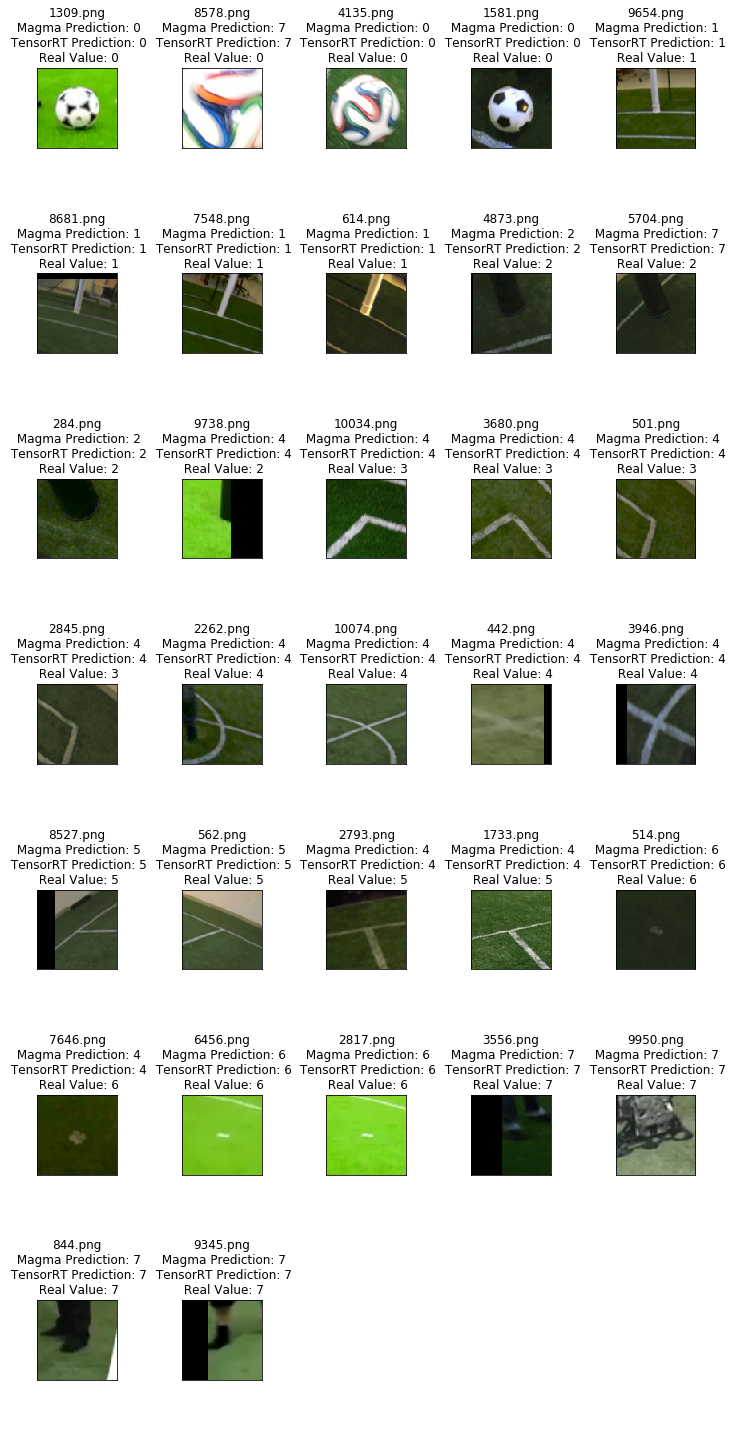

In [34]:
COLS = 5
rows = len(images)//COLS+1
print('COLS {}, rows {}'.format(COLS,rows))
fig, axes =  plt.subplots(nrows=rows, ncols=COLS, figsize=(10,20), constrained_layout=True)

# delete unused axes
for i in range( -(rows*COLS-len(images)),0):
    fig.delaxes(axes[rows-1,i])  

for idx, image in enumerate(images):
    col = idx%COLS
    row = idx//COLS
    
    img = load_img(path=image[0], color_mode='rgb', target_size=DATA_SHAPE)
    img = np.squeeze(img)
    axes[row,col].imshow(img,aspect='equal')
    axes[row,col].set_title('{}\n Magma Prediction: {}\n TensorRT Prediction: {}\n Real Value: {}'.format(
                        image[2], np.argmax(magma_pred[idx]),np.argmax(trt_pred[idx]), image[1]),fontsize=12)
    axes[row,col].tick_params(bottom=False, left=False,  labelleft=False, labelbottom=False)

#### 2) Accuracy

In [35]:
from sklearn.metrics import accuracy_score

magma_acc = accuracy_score(actual_values, magma_pred_values) * 100
trt_acc = accuracy_score(actual_values, trt_pred_values) * 100

print("Magma accuracy: ", magma_acc, "%")
print("TensorRT accuracy: ", trt_acc, "%")
print("Different:", magma_acc-trt_acc)

Magma accuracy:  68.75 %
TensorRT accuracy:  68.75 %
Different: 0.0


#### 3) Confusion matrix

In [36]:
from sklearn.metrics import confusion_matrix

confus_result = confusion_matrix(actual_values, trt_pred_max)
print(confus_result)

NameError: name 'trt_pred_max' is not defined

In [ ]:
def find_TP(confus_result, idx): # belong to a, classified as a
    return confus_result[idx][idx]

def find_FN(confus_result, idx): # belong to a, classified as others
    return sum([pred[idx] for i, pred in enumerate(confus_result) if i != idx])

def find_FP(confus_result, idx): # belong to others, classified as a
    return sum([num for i, num in enumerate(confus_result[idx]) if i != idx])

def find_TN(confus_result, idx): # belong to others, classified as others
    return sum(sum(confus_result)) - (find_FP(confus_result, idx) + find_FN(confus_result, idx) + find_TP(confus_result, idx))

idx = 0
print("Category:",idx)
print('TP:',find_TP(confus_result, idx))
print('FN:',find_FN(confus_result, idx))
print('FP:',find_FP(confus_result, idx))
print('TN:',find_TN(confus_result, idx))

#### 4) Recall score (also known as sensitivity)
the fraction of positives events that predicted correctly

\begin{equation*}
Recall = \frac{TP}{TP+FN}
\end{equation*}

In [ ]:
from sklearn.metrics import recall_score

print(recall_score(actual_values, trt_pred_max, average='micro'))
print(recall_score(actual_values, trt_pred_max, average='macro'))
print(recall_score(actual_values, trt_pred_max, average='weighted'))

#### 5) Precision score
the fraction of predicted positives events that are actually positive
\begin{equation*}
Precision = \frac{TP}{TP+FP}
\end{equation*}

In [ ]:
from sklearn.metrics import precision_score

print(precision_score(actual_values, trt_pred_max, average='micro'))
print(precision_score(actual_values, trt_pred_max, average='macro'))
print(precision_score(actual_values, trt_pred_max, average='weighted'))

#### 6) f1-score
The f1 score is the harmonic mean of recall and precision, with a higher score as a better model.

\begin{equation*}
F1 = \frac{2}{\frac{1}{precision}+\frac{1}{recall}} = \frac{2 * precision * recall}{precision + recall}
\end{equation*}

In [ ]:
from sklearn.metrics import f1_score

print(f1_score(actual_values, trt_pred_values, average='micro'))
print(f1_score(actual_values, trt_pred_values, average='macro'))
print(f1_score(actual_values, trt_pred_values, average='weighted'))

#### 7) ROC curve and roc_auc_score (area under curve) 
ROC (Receiver Operating Characteristics) curves are VERY help with understanding the balance between true-positive rate and false positive rates.

The roc_curve function returns three lists:
- thresholds = all unique prediction probabilities in descending order
- fpr = the false positive rate (FP / (FP + TN)) for each threshold
- tpr = the true positive rate (TP / (TP + FN)) for each threshold

https://stackabuse.com/understanding-roc-curves-with-python/

Using area under curve (AUC) metric to analyze the performance.

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import LabelBinarizer, label_binarize

def multiclass_roc_auc_score(truth, pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth,pred,average=average)

# TODO ROC for multiclasses
# ROC curve
fpr, tpr, thresholds = roc_curve(actual_values, trt_pred_values, pos_label=7)

print("fpr:",fpr)
print("tpr:",tpr)
print("thresholds:",thresholds)

# ROC AUC score
auc = multiclass_roc_auc_score(actual_values, trt_pred_values)
print('AUC:%.3f'% auc)

# Graph plot
plt.plot(fpr, tpr,'-r',label = 'Roc curve (area=%0.3f)'%auc,linewidth=5)
plt.plot([0,1],[0,1],'k--',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'y--',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()